# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
!pip install scipy==1.1.0

  Using cached scipy-1.1.0.tar.gz (15.6 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for scipy: filename=scipy-1.1.0-cp38-cp38-linux_x86_64.whl size=54472561 sha256=36b7a6bba8330223a20f2946d9f217ba94d4e660cd82463885ce8e94617da855
  Stored in directory: /home/.cache/pip/wheels/29/a9/5e/9e4eddde37a1e15cf5cb404ba197df482cc39ffbfef91ec337
Successfully built scipy
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.19.2 requires scipy>=1.4.1, but you have scipy 1.1.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [58]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [59]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)


## Utility functions

### Plotting accuracy and loss

In [60]:
# function to plot the training/validation accuracies/losses.
import cv2
import matplotlib.pyplot as plt


def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [70]:
# def generator(source_path, folder_list, batch_size):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
#     img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
#     while True:
#         t = np.random.permutation(folder_list)
#         num_batches = len(t) // batch_size # calculate the number of batches
#         for batch in range(num_batches): # we iterate over the number of batches
#             batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
#                     #crop the images and resize them. Note that the images are of 2 different shape 
#                     image = resize(image,(80,80)).astype(np.float32)
                    
#                     #and the conv3D will throw error if the inputs in a batch have different shapes
#                     batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
#                     batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
#                     batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
#         # write the code for the remaining data points which are left after full batches
#         if len(t) % batch_size != 0:
#             batch_data = np.zeros((batch_size,13,80,80,3)) 
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
#                     image = resize(image,(80,80)).astype(np.float32)
#                     batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
#                     batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
#                     batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does    

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [71]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
# from keras.layers.convolutional import Conv3D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from keras import optimizers
# from keras.layers import Dropout

#write your model here
# model = Sequential()
# model.add(Conv3D(32, (3, 3, 3), padding='same',
#          input_shape=(13,80,80,3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(128,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(64,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5,activation='softmax'))

In [72]:
# optimiser = 'sgd'
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [73]:
project_folder='/datasets/Project_data'

In [156]:
import abc
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def generator(self,source_path, folder_list, batch_size, augment=False):
#         print( 'Source path = ', source_path, '; batch size =', batch_size)
    
#     img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
    #             batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((batch_size,len(img_idx),self.image_height,self.image_width,3)) 
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
    #                     image = resize(image,(80,80)).astype(np.float32)
                        image = resize(image,(self.image_height,self.image_width)).astype(np.float32)
                        
                        # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                        if augment:
                            if np.random.randn() > 0:
                                image = datagen.random_transform(image)  
            
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            
#             batch_data = np.zeros((batch_size,13,80,80,3))
            batch_data = np.zeros((batch_size,len(img_idx),self.image_height,self.image_width,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(80,80)).astype(np.float32)
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)  
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does 


    def train_model(self, model, augment_data=False):
            train_generator = self.generator(self.train_path, self.train_doc, self.batch_size, augment=augment_data)
            val_generator = self.generator(self.val_path, self.val_doc, self.batch_size)

            model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

            if not os.path.exists(model_name):
                os.mkdir(model_name)

            filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

            checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
            LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

            earlystop = EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=1)
            callbacks_list = [checkpoint, LR, earlystop]

            if (self.num_train_sequences%self.batch_size) == 0:
                steps_per_epoch = int(self.num_train_sequences/self.batch_size)
            else:
                steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

            if (self.num_val_sequences%self.batch_size) == 0:
                validation_steps = int(self.num_val_sequences/self.batch_size)
            else:
                validation_steps = (self.num_val_sequences//self.batch_size) + 1

#             history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
#                                 callbacks=callbacks_list, validation_data=val_generator, 
#                                 validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
            history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
            return history


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Model 1: Base Model - Image size = (80 x 80). Batch Size = 40 and Epoch= 15

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [122]:

class Model1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [123]:
conv_model1_obj=Model1()
conv_model1_obj.initialize_path(project_folder)
conv_model1_obj.initialize_image_properties(image_height=80,image_width=80)
conv_model1_obj.initialize_hyperparams(frames_to_sample=13,batch_size=40,num_epochs=15)
conv_model1_model=conv_model1_obj.define_model()
conv_model1_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_42 (Conv3D)          (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_42 (Activation)  (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_70 (Bat  (None, 13, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_42 (MaxPoolin  (None, 6, 40, 40, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_43 (Conv3D)          (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_43 (Activation)  (None, 6, 40, 40, 64)   

In [124]:
print("Total Params:", conv_model1_model.count_params())

Total Params: 1733509


In [118]:
training_output_model1 = conv_model1_obj.train_model(conv_model1_model)

Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 1.6731 - categorical_accuracy: 0.3971
Epoch 00001: val_loss improved from inf to 1.57510, saving model to model_init_2025-01-2819_33_28.112901/model-00001-1.67308-0.39706-1.57510-0.24167.h5
17/17 [==============================] - 75s 5s/step - loss: 1.6731 - categorical_accuracy: 0.3971 - val_loss: 1.5751 - val_categorical_accuracy: 0.2417 - lr: 0.0100
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 1.0754 - categorical_accuracy: 0.5750
Epoch 00002: val_loss did not improve from 1.57510
17/17 [==============================] - 75s 5s/step - loss: 1.0754 - categorical_accuracy: 0.5750 - val_loss: 1.7046 - val_categorical_accuracy: 0.1500 - lr: 0.0100
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 0.7882 - categorical_accuracy: 0.6868
Epoch 00003: val_loss did not improve from 1.57510
17/17 [==============================] - 75s 5s/step - loss: 0.7882 - categorical_accuracy: 0.6868 

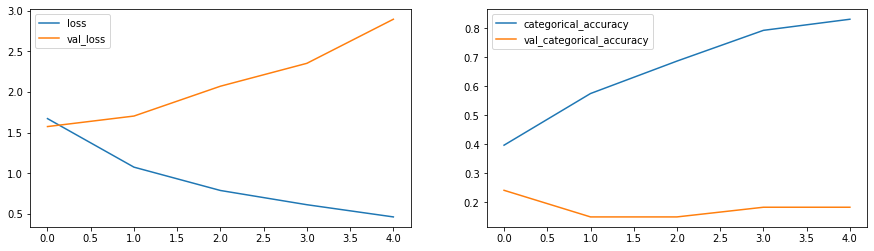

In [120]:
plot(training_output_model1)

Our model is seemingly overfitting.

## Model 2: Increase the Batch size to 64 and Epochs to 20. Also increase the image resolution to 120


In above model we see the validation accuracy is varing wildly. Adding more epochs may give the stable validation accuracy. Before doing that we would try what effect batch_size of 64 have on the model. For this model we will try batch_zise and 64

In [127]:

class Model2(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [128]:
conv_model2_obj=Model2()
conv_model2_obj.initialize_path(project_folder)
conv_model2_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model2_obj.initialize_hyperparams(frames_to_sample=13,batch_size=64,num_epochs=20)
conv_model2_model=conv_model2_obj.define_model()
conv_model2_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 13, 120, 120, 32)  2624      
                                                                 
 activation_48 (Activation)  (None, 13, 120, 120, 32)  0         
                                                                 
 batch_normalization_80 (Bat  (None, 13, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 6, 60, 60, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 6, 60, 60, 64)     16448     
                                                                 
 activation_49 (Activation)  (None, 6, 60, 60, 64)   

In [129]:
print("Total Params:", conv_model2_model.count_params())

Total Params: 3781509


In [130]:
training_output_model2 = conv_model2_obj.train_model(conv_model2_model)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5387 - categorical_accuracy: 0.4702
Epoch 00001: val_loss improved from inf to 1.59490, saving model to model_init_2025-01-2819_51_12.870779/model-00001-1.53871-0.47017-1.59490-0.22656.h5
11/11 [==============================] - 81s 8s/step - loss: 1.5387 - categorical_accuracy: 0.4702 - val_loss: 1.5949 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.9710 - categorical_accuracy: 0.6278
Epoch 00002: val_loss did not improve from 1.59490
11/11 [==============================] - 78s 8s/step - loss: 0.9710 - categorical_accuracy: 0.6278 - val_loss: 1.7473 - val_categorical_accuracy: 0.2344 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.5936 - categorical_accuracy: 0.7912
Epoch 00003: val_loss did not improve from 1.59490
11/11 [==============================] - 81s 8s/step - loss: 0.5936 - categorical_accuracy: 0.79

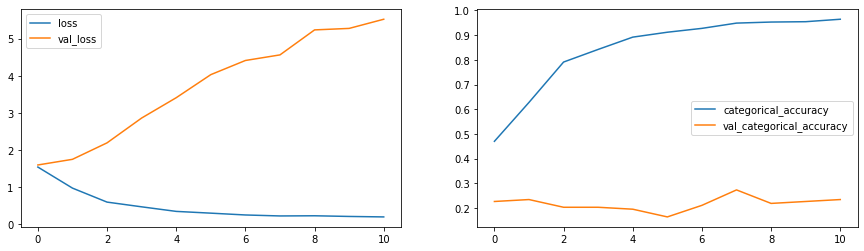

In [139]:
plot(training_output_model2)

## Model 3: Data Augmentation and frames_per_sample 20

In [143]:

class Model3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [144]:
conv_model3_obj=Model3()
conv_model3_obj.initialize_path(project_folder)
conv_model3_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model3_obj.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=15)
conv_model3_model=conv_model3_obj.define_model()
conv_model3_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_63 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_63 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization_105 (Ba  (None, 20, 120, 120, 32)  128      
 tchNormalization)                                               
                                                                 
 max_pooling3d_63 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_64 (Conv3D)          (None, 10, 60, 60, 64)    16448     
                                                                 
 activation_64 (Activation)  (None, 10, 60, 60, 64)  

In [145]:
print("Total Params:", conv_model3_model.count_params())

Total Params: 7467909


In [149]:
training_output_model3 = conv_model3_obj.train_model(conv_model3_model, augment_data=True)

Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.6070 - categorical_accuracy: 0.4205 
Epoch 00001: val_loss improved from inf to 1.64988, saving model to model_init_2025-01-2820_33_44.740223/model-00001-1.60700-0.42045-1.64988-0.30469.h5
11/11 [==============================] - 148s 15s/step - loss: 1.6070 - categorical_accuracy: 0.4205 - val_loss: 1.6499 - val_categorical_accuracy: 0.3047 - lr: 0.0100
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.0145 - categorical_accuracy: 0.6207 
Epoch 00002: val_loss did not improve from 1.64988
11/11 [==============================] - 136s 14s/step - loss: 1.0145 - categorical_accuracy: 0.6207 - val_loss: 2.0183 - val_categorical_accuracy: 0.1406 - lr: 0.0100
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.8197 - categorical_accuracy: 0.6903 
Epoch 00003: val_loss did not improve from 1.64988
11/11 [==============================] - 136s 14s/step - loss: 0.8197 - categorical_accur

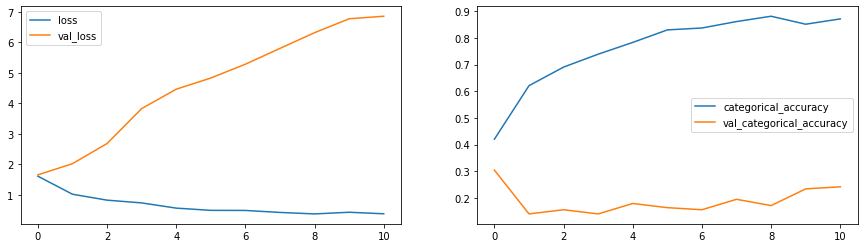

In [150]:
plot(training_output_model3)

## Model 4: Changing the filter size to (2x2x2). Maintaining the Image Resolution at 120x120 and increase Frames_per_sample 20


In [ ]:

class Model4(ModelBuilder):
    
    def define_model(self,filtersize=(2,2,2),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_model4_obj=Model4()
conv_model4_obj.initialize_path(project_folder)
conv_model4_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model4_obj.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=20)
conv_model4_model=conv_model4_obj.define_model()
conv_model4_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_57 (Conv3D)          (None, 13, 120, 120, 32)  2624      
                                                                 
 activation_57 (Activation)  (None, 13, 120, 120, 32)  0         
                                                                 
 batch_normalization_95 (Bat  (None, 13, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_57 (MaxPoolin  (None, 6, 60, 60, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_58 (Conv3D)          (None, 6, 60, 60, 64)     16448     
                                                                 
 activation_58 (Activation)  (None, 6, 60, 60, 64)   

In [ ]:
print("Total Params:", conv_model4_model.count_params())

Total Params: 3781509


In [ ]:
training_output_model4 = conv_model4_obj.train_model(conv_model4_model)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5387 - categorical_accuracy: 0.4702
Epoch 00001: val_loss improved from inf to 1.59490, saving model to model_init_2025-01-2819_51_12.870779/model-00001-1.53871-0.47017-1.59490-0.22656.h5
11/11 [==============================] - 81s 8s/step - loss: 1.5387 - categorical_accuracy: 0.4702 - val_loss: 1.5949 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.9710 - categorical_accuracy: 0.6278
Epoch 00002: val_loss did not improve from 1.59490
11/11 [==============================] - 78s 8s/step - loss: 0.9710 - categorical_accuracy: 0.6278 - val_loss: 1.7473 - val_categorical_accuracy: 0.2344 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.5936 - categorical_accuracy: 0.7912
Epoch 00003: val_loss did not improve from 1.59490
11/11 [==============================] - 81s 8s/step - loss: 0.5936 - categorical_accuracy: 0.79

In [ ]:
plot(training_output_model4)

NameError: name 'training_output_model4' is not defined

## Model 5: Adding more Layers


In above model we see the validation accuracy is varing wildly. Adding more epochs may give the stable validation accuracy. Before doing that we would try what effect batch_size of 64 have on the model. For this model we will try batch_zise and 64

In [ ]:

class Model5(ModelBuilder):
       
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "Adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_model5_obj=Model5()
conv_model5_obj.initialize_path(project_folder)
conv_model5_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model5_obj.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=20)
conv_model5_model=conv_model5_obj.define_model()
conv_model5_model.summary()

In [ ]:
print("Total Params:", conv_model5_model.count_params())

In [ ]:
training_output_model5 = conv_model5_obj.train_model(conv_model5_model)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5387 - categorical_accuracy: 0.4702
Epoch 00001: val_loss improved from inf to 1.59490, saving model to model_init_2025-01-2819_51_12.870779/model-00001-1.53871-0.47017-1.59490-0.22656.h5
11/11 [==============================] - 81s 8s/step - loss: 1.5387 - categorical_accuracy: 0.4702 - val_loss: 1.5949 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.9710 - categorical_accuracy: 0.6278
Epoch 00002: val_loss did not improve from 1.59490
11/11 [==============================] - 78s 8s/step - loss: 0.9710 - categorical_accuracy: 0.6278 - val_loss: 1.7473 - val_categorical_accuracy: 0.2344 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.5936 - categorical_accuracy: 0.7912
Epoch 00003: val_loss did not improve from 1.59490
11/11 [==============================] - 81s 8s/step - loss: 0.5936 - categorical_accuracy: 0.79

In [ ]:
plot(training_output_model5)

## Model 6: Adding Drop outs to convolution layer


In above model we see the validation accuracy is varing wildly. Adding more epochs may give the stable validation accuracy. Before doing that we would try what effect batch_size of 64 have on the model. For this model we will try batch_zise and 64

In [ ]:

class Model6(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_model6_obj=Model6()
conv_model6_obj.initialize_path(project_folder)
conv_model6_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model6_obj.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=20)
conv_model6_model=conv_model6_obj.define_model()
conv_model6_model.summary()

In [ ]:
print("Total Params:", conv_model6_model.count_params())

In [ ]:
training_output_model6 = conv_model6_obj.train_model(conv_model6_model)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5387 - categorical_accuracy: 0.4702
Epoch 00001: val_loss improved from inf to 1.59490, saving model to model_init_2025-01-2819_51_12.870779/model-00001-1.53871-0.47017-1.59490-0.22656.h5
11/11 [==============================] - 81s 8s/step - loss: 1.5387 - categorical_accuracy: 0.4702 - val_loss: 1.5949 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.9710 - categorical_accuracy: 0.6278
Epoch 00002: val_loss did not improve from 1.59490
11/11 [==============================] - 78s 8s/step - loss: 0.9710 - categorical_accuracy: 0.6278 - val_loss: 1.7473 - val_categorical_accuracy: 0.2344 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.5936 - categorical_accuracy: 0.7912
Epoch 00003: val_loss did not improve from 1.59490
11/11 [==============================] - 81s 8s/step - loss: 0.5936 - categorical_accuracy: 0.79

In [ ]:
plot(training_output_model6)

## Model 7: CNN + LSTM


In above model we see the validation accuracy is varing wildly. Adding more epochs may give the stable validation accuracy. Before doing that we would try what effect batch_size of 64 have on the model. For this model we will try batch_zise and 64

In [ ]:
from keras.layers.recurrent import LSTM


class CNNLSTM(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam(lr=0.002)
#         optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
  
     

In [ ]:
cnn_lstm=CNNLSTM()
cnn_lstm.initialize_path(project_folder)
cnn_lstm.initialize_image_properties(image_height=120,image_width=120)
cnn_lstm.initialize_hyperparams(frames_to_sample=18,batch_size=32,num_epochs=20)
cnn_lstm_model=cnn_lstm.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnn_lstm_model.summary()

In [ ]:
print("Total Params:", cnn_lstm_model.count_params())

In [175]:
training_output_model7 = cnn_lstm.train_model(cnn_lstm_model)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.5693 - categorical_accuracy: 0.8423
Epoch 00001: val_loss improved from inf to 1.69906, saving model to model_init_2025-01-2821_33_36.941985/model-00001-0.56926-0.84226-1.69906-0.35938.h5
21/21 [==============================] - 100s 5s/step - loss: 0.5693 - categorical_accuracy: 0.8423 - val_loss: 1.6991 - val_categorical_accuracy: 0.3594 - lr: 0.0020
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.5552 - categorical_accuracy: 0.8363
Epoch 00002: val_loss did not improve from 1.69906
21/21 [==============================] - 107s 5s/step - loss: 0.5552 - categorical_accuracy: 0.8363 - val_loss: 1.7089 - val_categorical_accuracy: 0.3359 - lr: 0.0020
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.5452 - categorical_accuracy: 0.8497
Epoch 00003: val_loss did not improve from 1.69906
21/21 [==============================] - 105s 5s/step - loss: 0.5452 - categorical_accuracy: 0

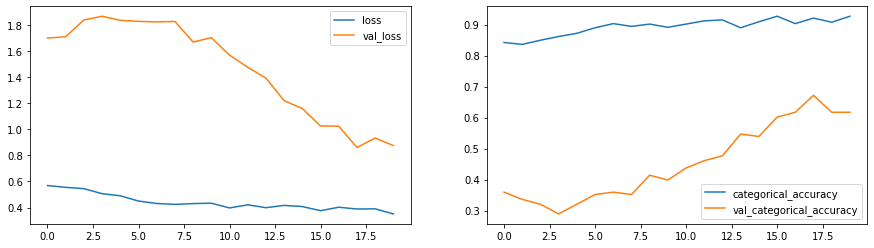

In [176]:
plot(training_output_model7)

## Model 8: CNN + LSTM


In above model we see the validation accuracy is varing wildly. Adding more epochs may give the stable validation accuracy. Before doing that we would try what effect batch_size of 64 have on the model. For this model we will try batch_zise and 64

In [ ]:

class Model4(ModelBuilder):
    
    def define_model(self,filtersize=(2,2,2),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_model4_obj=Model4()
conv_model4_obj.initialize_path(project_folder)
conv_model4_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model4_obj.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=20)
conv_model4_model=conv_model2_obj.define_model()
conv_model4_model.summary()

In [ ]:
print("Total Params:", conv_model4_model.count_params())

In [ ]:
training_output_model4 = conv_model4_obj.train_model(conv_model4_model)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5387 - categorical_accuracy: 0.4702
Epoch 00001: val_loss improved from inf to 1.59490, saving model to model_init_2025-01-2819_51_12.870779/model-00001-1.53871-0.47017-1.59490-0.22656.h5
11/11 [==============================] - 81s 8s/step - loss: 1.5387 - categorical_accuracy: 0.4702 - val_loss: 1.5949 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.9710 - categorical_accuracy: 0.6278
Epoch 00002: val_loss did not improve from 1.59490
11/11 [==============================] - 78s 8s/step - loss: 0.9710 - categorical_accuracy: 0.6278 - val_loss: 1.7473 - val_categorical_accuracy: 0.2344 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.5936 - categorical_accuracy: 0.7912
Epoch 00003: val_loss did not improve from 1.59490
11/11 [==============================] - 81s 8s/step - loss: 0.5936 - categorical_accuracy: 0.79

In [ ]:
plot(training_output_model4)

## Model 9: CNN + LSTM


In above model we see the validation accuracy is varing wildly. Adding more epochs may give the stable validation accuracy. Before doing that we would try what effect batch_size of 64 have on the model. For this model we will try batch_zise and 64

In [ ]:

class Model4(ModelBuilder):
    
    def define_model(self,filtersize=(2,2,2),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_model4_obj=Model4()
conv_model4_obj.initialize_path(project_folder)
conv_model4_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model4_obj.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=20)
conv_model4_model=conv_model2_obj.define_model()
conv_model4_model.summary()

In [ ]:
print("Total Params:", conv_model4_model.count_params())

In [ ]:
training_output_model4 = conv_model4_obj.train_model(conv_model4_model)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5387 - categorical_accuracy: 0.4702
Epoch 00001: val_loss improved from inf to 1.59490, saving model to model_init_2025-01-2819_51_12.870779/model-00001-1.53871-0.47017-1.59490-0.22656.h5
11/11 [==============================] - 81s 8s/step - loss: 1.5387 - categorical_accuracy: 0.4702 - val_loss: 1.5949 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.9710 - categorical_accuracy: 0.6278
Epoch 00002: val_loss did not improve from 1.59490
11/11 [==============================] - 78s 8s/step - loss: 0.9710 - categorical_accuracy: 0.6278 - val_loss: 1.7473 - val_categorical_accuracy: 0.2344 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.5936 - categorical_accuracy: 0.7912
Epoch 00003: val_loss did not improve from 1.59490
11/11 [==============================] - 81s 8s/step - loss: 0.5936 - categorical_accuracy: 0.79

In [ ]:
plot(training_output_model4)